# Data Challenge - Akshay Tiwari

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

import matplotlib.pyplot as plt
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics, cross_validation
from sklearn.model_selection import cross_validate,train_test_split,GridSearchCV, KFold, cross_val_score
from sklearn import preprocessing
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, fbeta_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [3]:
data = pd.read_csv('train_data.csv', parse_dates=['apply_date', 'earliest_cr_line'])
data.head()

,id,loan_status,mths_since_last_major_derog,revol_bal,purpose,addr_state,title,home_ownership,application_type,verification_status_joint,earliest_cr_line,apply_date,verification_status,emp_length,dti,emp_title,annual_inc
0,63480419,Current,NaN,15954,debt_consolidation,KS,Debt consolidation,MORTGAGE,INDIVIDUAL,NaN,5-Aug,15-Nov,Not Verified,5 years,24.85,Branch Office Administrator,62000.0
1,51386490,Current,NaN,73814,debt_consolidation,MD,Debt consolidation,MORTGAGE,INDIVIDUAL,NaN,Sep-83,15-Jun,Verified,10+ years,26.38,IIntelligence Analyst,113000.0
2,13567696,Current,NaN,30013,major_purchase,TX,Major purchase,OWN,INDIVIDUAL,NaN,Dec-99,14-Apr,Not Verified,10+ years,14.41,Global Service Delivery Lead,180000.0
3,22252931,Fully Paid,NaN,10768,credit_card,DE,Credit card refinancing,MORTGAGE,INDIVIDUAL,NaN,1-Sep,14-Jul,Not Verified,10+ years,24.31,Operations Manager,66000.0
4,6539569,Fully Paid,NaN,35551,home_improvement,WI,Home Improvement,MORTGAGE,INDIVIDUAL,NaN,Dec-92,13-Aug,Verified,2 years,1.70,Coram Specialty Infusion,110000.0


- Generating a binary response variable as per the criteria mentioned in the question

In [4]:
data.loan_status.value_counts()

Current                                                135528
Fully Paid                                              46837
Charged Off                                             10270
Late (31-120 days)                                       2626
Issued                                                   1919
In Grace Period                                          1411
Late (16-30 days)                                         509
Does not meet the credit policy. Status:Fully Paid        452
Default                                                   288
Does not meet the credit policy. Status:Charged Off       160
Name: loan_status, dtype: int64

In [5]:
data['res'] = (data['loan_status']=='Charged Off').astype(int) + (data['loan_status']=='Late (31-120 days)').astype(int) + (data['loan_status']=='Default').astype(int) + (data['loan_status']=='Does not meet the credit policy. Status:Charged Off').astype(int)
data.drop('loan_status', axis=1, inplace=True)

- I have converted 'Charged Off', 'Late (31-120 days)', 'Default' and 'Does not meet the credit policy. Status:Charged Off' as 1 and others as 0 in the reponse variable, which will be used for a binary classification

# Q-1 - EDA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 17 columns):
id                             200000 non-null int64
mths_since_last_major_derog    49745 non-null float64
revol_bal                      200000 non-null int64
purpose                        200000 non-null object
addr_state                     200000 non-null object
title                          199964 non-null object
home_ownership                 200000 non-null object
application_type               200000 non-null object
verification_status_joint      111 non-null object
earliest_cr_line               200000 non-null object
apply_date                     200000 non-null object
verification_status            200000 non-null object
emp_length                     189735 non-null object
dti                            200000 non-null float64
emp_title                      188207 non-null object
annual_inc                     199998 non-null float64
res                         

In [7]:
data.describe()

,id,mths_since_last_major_derog,revol_bal,dti,annual_inc,res
count,2.000000e+05,49745.000000,2.000000e+05,200000.000000,1.999980e+05,200000.000000
mean,3.243004e+07,44.136134,1.692455e+04,18.146953,7.519197e+04,0.066720
std,2.282037e+07,22.258667,2.165016e+04,23.809379,6.343685e+04,0.249537
min,5.574200e+04,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,9.197932e+06,27.000000,6.440000e+03,11.890000,4.500000e+04,0.000000
50%,3.441335e+07,44.000000,1.188600e+04,17.620000,6.500000e+04,0.000000
75%,5.488857e+07,62.000000,2.084525e+04,23.890000,9.000000e+04,0.000000
max,6.861676e+07,180.000000,1.190046e+06,9999.000000,7.500000e+06,1.000000


### Imputing Missing values

- As we see a lot of null values, we'll impute that based on following logic:
    - mths_since_last_major_derog: 0 [assuming it was less than a month]
    - verification_status_joint: Not Verified [assuming nulls are not verified]
    - emp_length: 0 [assuming the employee has recently entered the system]
    - emp_title: unknown [giving a seperate category as unknown]
    - annual_inc: mean of same emp_title [salary will be compareble in the same emp_title]
    - earliest_cr_line: Remove [as the number of null observations are low]
    - title: Remove [as the number of null observations are low]

- mths_since_last_major_derog

In [8]:
data.mths_since_last_major_derog.fillna(0, inplace=True)

- verification_status_joint

In [9]:
data.verification_status_joint.fillna('Not Verified', inplace=True)

- emp_length

In [10]:
data.emp_length.fillna(0, inplace=True)

- emp_title

In [11]:
data.emp_title.fillna('Unknown', inplace=True)

- annual_inc

In [12]:
tmp_data = pd.DataFrame(data= data.groupby(['emp_title'])['annual_inc'].mean()).reset_index()

In [13]:
def imp_inc(x):
    if(pd.isnull(x['annual_inc'])):
        try :
            x['annual_inc'] = float(tmp_data.loc[tmp_data['emp_title'] == x['emp_title'], 'annual_inc'])
        except :
            print (tmp_data[x['emp_title']], x)
    else:
        x['annual_inc'] = float(x['annual_inc'])
    return x

In [14]:
data = data.apply(lambda x : imp_inc(x), axis=1)

- earliest_cr_line

In [15]:
data.dropna(subset=['earliest_cr_line'], inplace=True)

- title

In [16]:
data.dropna(subset=['title'], inplace=True)

- Checking the null values now

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199964 entries, 0 to 199999
Data columns (total 17 columns):
id                             199964 non-null int64
mths_since_last_major_derog    199964 non-null float64
revol_bal                      199964 non-null int64
purpose                        199964 non-null object
addr_state                     199964 non-null object
title                          199964 non-null object
home_ownership                 199964 non-null object
application_type               199964 non-null object
verification_status_joint      199964 non-null object
earliest_cr_line               199964 non-null object
apply_date                     199964 non-null object
verification_status            199964 non-null object
emp_length                     199964 non-null object
dti                            199964 non-null float64
emp_title                      199964 non-null object
annual_inc                     199964 non-null float64
res                     

### Encoding categorical to numeric (Label encoding and Feature engineering)

- Engineering dates to other useful features such as year, month, time of the year, etc.

In [18]:
import re

def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Dayofweek', 'Dayofyear'):
        df[targ_pre+n] = getattr(fld.dt,n.lower()).astype(float)

    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [19]:
data['apply_date'] = data.apply_date.apply(lambda x: '0'+x if len(x)==5 else x )
data['apply_date'] = pd.to_datetime(data.apply_date,format = '%y-%b')
add_datepart(data, 'apply_date')

In [20]:
def cr_line_check(x):
    cr_line = x['earliest_cr_line']
    if not cr_line[-3:].isalpha():
        if len(cr_line)==5:
            cr_line = '0' + '-'.join(cr_line.split('-')[::-1])
        else:
            cr_line = '-'.join(cr_line.split('-')[::-1])
    else:
        if len(cr_line)==5:
            cr_line = '0' + cr_line
    x['earliest_cr_line'] = cr_line
    return x

In [21]:
data = data.apply(lambda x : cr_line_check(x), axis=1)
data['earliest_cr_line'] = pd.to_datetime(data.earliest_cr_line, format = '%y-%b')
add_datepart(data, 'earliest_cr_line')

- Engineering other features into numerical 

In [22]:
data.emp_length.value_counts()

10+ years    65635
2 years      17700
< 1 year     15868
3 years      15830
1 year       12928
5 years      12527
4 years      11842
0            10263
7 years      10055
8 years       9859
6 years       9745
9 years       7712
Name: emp_length, dtype: int64

In [23]:
emp_length_map = {
    '< 1 year':0,
    '1 year':1,
    '2 years':2,
    '3 years':3,
    '4 years':4,
    '5 years':5,
    '6 years':6,
    '7 years':7,
    '8 years':8,
    '9 years':9,
    '10+ years':10
}
data['emp_length'] = data['emp_length'].map(emp_length_map)
data.emp_length.fillna(0, inplace=True)

In [24]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199964 entries, 0 to 199999
Data columns (total 27 columns):
id                             199964 non-null int64
mths_since_last_major_derog    199964 non-null float64
revol_bal                      199964 non-null int64
purpose                        199964 non-null object
addr_state                     199964 non-null object
title                          199964 non-null object
home_ownership                 199964 non-null object
application_type               199964 non-null object
verification_status_joint      199964 non-null object
verification_status            199964 non-null object
emp_length                     199964 non-null float64
dti                            199964 non-null float64
emp_title                      199964 non-null object
annual_inc                     199964 non-null float64
res                            199964 non-null int64
apply_Year                     199964 non-null float64
apply_Month            

In [26]:
cols_to_encode = ['purpose', 'addr_state', 'title', 'home_ownership', 'application_type', 'verification_status_joint',
                 'verification_status', 'emp_title']
df = data.copy()

In [27]:
# Encoding the variable
df[cols_to_encode] = df[cols_to_encode].apply(lambda x: d[x.name].fit_transform(x))

In [28]:
# code to decode the label encoded values

# Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
# df.apply(lambda x: d[x.name].transform(x))

### Looking at the data (Visualizations and statistics)

- Class balance

In [29]:
df.res.value_counts() / len(data)

0    0.933268
1    0.066732
Name: res, dtype: float64

- As we can see, class is highly imbalanced with defaults being only 6.63%

In [30]:
df.iloc[0]

id                             6.348042e+07
mths_since_last_major_derog    0.000000e+00
revol_bal                      1.595400e+04
purpose                        2.000000e+00
addr_state                     1.600000e+01
title                          4.799000e+03
home_ownership                 1.000000e+00
application_type               0.000000e+00
verification_status_joint      0.000000e+00
verification_status            0.000000e+00
emp_length                     5.000000e+00
dti                            2.485000e+01
emp_title                      8.352000e+03
annual_inc                     6.200000e+04
res                            0.000000e+00
apply_Year                     2.015000e+03
apply_Month                    1.100000e+01
apply_Week                     4.400000e+01
apply_Dayofweek                6.000000e+00
apply_Dayofyear                3.050000e+02
apply_Elapsed                  1.446336e+09
earliest_cr_lineYear           2.005000e+03
earliest_cr_lineMonth          8

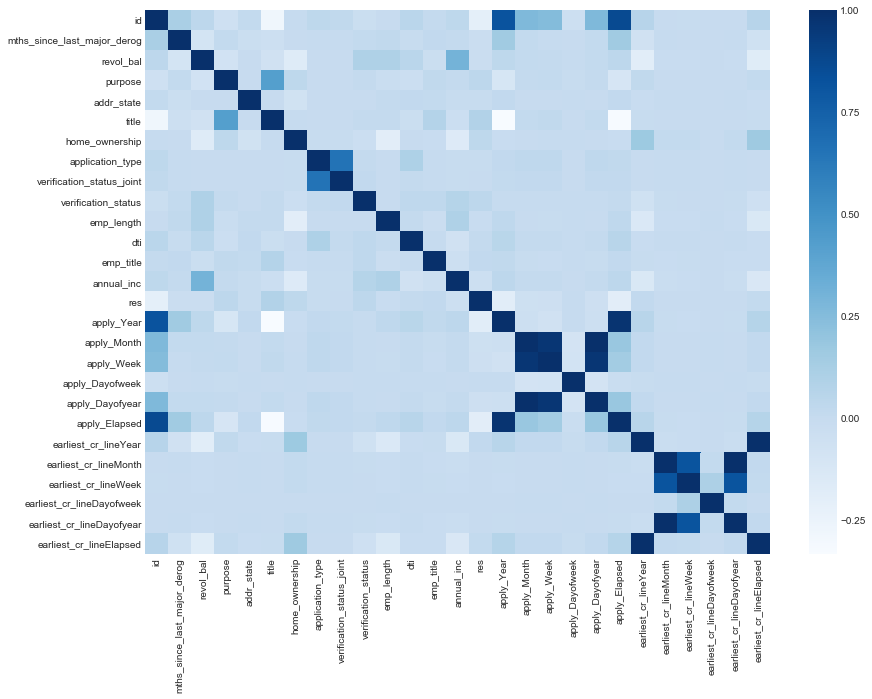

In [31]:
import seaborn as sns
sns.set_style("whitegrid")

fig = plt.figure(figsize=(14,10))
# sns.set(font_scale=1.2)
numerical_feature=data.dtypes[data.dtypes!= 'object'].index
corr = df.corr()
sns.heatmap(corr, cmap='Blues')

In [32]:
default_rate_per_month = df.groupby(['apply_Year', 'apply_Month'])['res'].mean().reset_index().sort_values(by=['apply_Year', 'apply_Month'])
default_rate_per_month

,apply_Year,apply_Month,res
0,2007.0,6.0,0.250000
1,2007.0,7.0,0.100000
2,2007.0,8.0,0.222222
3,2007.0,9.0,0.272727
4,2007.0,10.0,0.384615
5,2007.0,11.0,0.275862
6,2007.0,12.0,0.275862
7,2008.0,1.0,0.232877
8,2008.0,2.0,0.158537
9,2008.0,3.0,0.220930


In [33]:
default_rate_per_month['year_month'] = default_rate_per_month.apply(lambda x : str(int(x.apply_Year)) + '_' + str(int(x.apply_Month)), axis=1)

In [34]:
plot_data = [go.Scatter(x=default_rate_per_month.year_month, y=default_rate_per_month.res)]

layout = dict(
    title = "Trend in Defaults over application time",
    xaxis=dict(
        title='Time-Year/Month'
    ),
    yaxis=dict(
        title='Number of defaults'
    )
)

fig = dict(data=plot_data, layout=layout)
iplot(fig)

In [35]:
df.earliest_cr_lineYear.value_counts()

2001.0    14280
2000.0    14247
1999.0    12908
2002.0    12825
2003.0    11992
1998.0    10908
2004.0    10547
1997.0     9318
1996.0     9127
2005.0     8820
1995.0     8556
1994.0     7662
2006.0     7240
1993.0     6349
2007.0     5694
1992.0     4419
1990.0     4355
1991.0     4249
1989.0     4006
2008.0     3664
1988.0     3391
1987.0     2918
1986.0     2525
2009.0     2185
1985.0     2177
1984.0     2056
2010.0     1735
1983.0     1702
2011.0     1380
1982.0     1337
1981.0      965
1979.0      855
1978.0      786
1980.0      760
1977.0      719
1976.0      555
2012.0      458
1975.0      406
1973.0      313
1974.0      306
1972.0      244
1971.0      171
1970.0      163
1969.0      154
2068.0      116
2067.0      114
2065.0       78
2066.0       70
2064.0       38
2063.0       37
2062.0       18
2059.0       16
2061.0       11
2060.0       10
2056.0        4
2055.0        3
2044.0        2
2057.0        2
2058.0        2
2050.0        2
2053.0        1
2052.0        1
2051.0  

- Credit lines couldn't have been opened after 2015 in our dataset which means bigger values like (2051, 2068, etc.) are mistakes

In [36]:
df = df[df.earliest_cr_lineYear<2016]
len(df)

199427

In [37]:
default_rate_per_month = df.groupby(['earliest_cr_lineYear', 'earliest_cr_lineMonth'])['res'].mean().reset_index().sort_values(by=['earliest_cr_lineYear', 'earliest_cr_lineMonth'])
default_rate_per_month

,earliest_cr_lineYear,earliest_cr_lineMonth,res
0,1969.0,1.0,0.090909
1,1969.0,2.0,0.000000
2,1969.0,3.0,0.000000
3,1969.0,4.0,0.000000
4,1969.0,5.0,0.000000
5,1969.0,6.0,0.187500
6,1969.0,7.0,0.100000
7,1969.0,8.0,0.000000
8,1969.0,9.0,0.083333
9,1969.0,10.0,0.047619


In [38]:
default_rate_per_month['year_month'] = default_rate_per_month.apply(lambda x : str(int(x.earliest_cr_lineYear)) + '_' + str(int(x.earliest_cr_lineMonth)), axis=1)

In [39]:
plot_data = [go.Scatter(x=default_rate_per_month.year_month, y=default_rate_per_month.res)]

layout = dict(
    title = "Trend in Defaults over earliest credit line time",
    xaxis=dict(
        title='Time-Year/Month'
    ),
    yaxis=dict(
        title='Number of defaults'
    )
)

fig = dict(data=plot_data, layout=layout)
iplot(fig)

In [40]:
default_rate_per_month = df.groupby(['earliest_cr_lineYear', 'earliest_cr_lineMonth'])['annual_inc'].mean().reset_index().sort_values(by=['earliest_cr_lineYear', 'earliest_cr_lineMonth'])
default_rate_per_month

,earliest_cr_lineYear,earliest_cr_lineMonth,annual_inc
0,1969.0,1.0,82642.272727
1,1969.0,2.0,83294.816667
2,1969.0,3.0,85915.933333
3,1969.0,4.0,80887.750000
4,1969.0,5.0,86702.181818
5,1969.0,6.0,84347.130000
6,1969.0,7.0,81542.300000
7,1969.0,8.0,60637.250000
8,1969.0,9.0,74020.073333
9,1969.0,10.0,86877.523810


In [41]:
default_rate_per_month['year_month'] = default_rate_per_month.apply(lambda x : str(int(x.earliest_cr_lineYear)) + '_' + str(int(x.earliest_cr_lineMonth)), axis=1)

In [42]:
plot_data = [go.Scatter(x=default_rate_per_month.year_month, y=default_rate_per_month.annual_inc)]

layout = dict(
    title = "Trend in annual income over earliest credit line time",
    xaxis=dict(
        title='Time-Year/Month'
    ),
    yaxis=dict(
        title='Number of defaults'
    )
)

fig = dict(data=plot_data, layout=layout)
iplot(fig)

In [43]:
data.home_ownership.value_counts()

MORTGAGE    100090
RENT         80038
OWN          19777
OTHER           48
NONE            10
ANY              1
Name: home_ownership, dtype: int64

In [44]:
default_rate_home_ownership = df.groupby(['home_ownership'])['res'].mean().reset_index().sort_values(by=['home_ownership'])
default_rate_home_ownership

,home_ownership,res
0,0,0.000000
1,1,0.058775
2,2,0.250000
3,3,0.166667
4,4,0.059699
5,5,0.078227


In [45]:
import plotly.plotly as py
import plotly.graph_objs as go

x = default_rate_home_ownership.home_ownership
y = default_rate_home_ownership.res

plot_data = [go.Bar(
            x=x,
            y=y
    )]

iplot(plot_data, filename='basic-bar')

- We see that people with 'mortgage' have the highest default rate followed by people living on Rent

# Q-2


## Training and Validation

### preparing the data for training

In [46]:
print ('Dimension of each observation : ', (df[:1].shape))
print ('Shape of the training set : ', df.shape)

Dimension of each observation :  (1, 27)
Shape of the training set :  (199427, 27)


In [47]:
df, res = df.loc[:, df.columns != 'res'], df.res
x_train, x_test, y_train, y_test = train_test_split(df, res, test_size=0.2, random_state=3)

In [48]:
print('Shape of Training data : ', x_train.shape)
print('Shape of Testing data : ', x_test.shape)

Shape of Training data :  (159541, 26)
Shape of Testing data :  (39886, 26)


In [49]:
valueCounts = y_train.value_counts() / len(y_train)
print ('Checking balance of response variable in Training set:\n', valueCounts)

Checking balance of response variable in Training set:
 0    0.933196
1    0.066804
Name: res, dtype: float64


### Validation metrics

- F1 score : F-score is based on the precision and recall of the results which means that it individually focuses on prediction of each class rather than a common accuracy. In cases like these where dataset is imbalanced, the accuracy might turn out to be high by just predicting all observations as negatives (or majority class), but in reality out model is not performing well at all as it is not able to classify between the two classes. 
- F(2) score / F(0.5) score : F(2) or F(0.5) scores can also be used depending on the use-case and requirement of reducing false positives or false negatives.
- Confusion matrix gives us a good overview at each step about the performance of the model in each section of the prediction. 
- AUC precision-recall curve : Area under the precision recall curve tells us the precision and recall performance irrespective of the threshold put on the predicted probability (soft predictions) to convert it into 1 & 0 (hard predictions).
- Below I have tracked multiple metrics to make a comparision.

In [50]:
def score_res(true_res, pred_res, pred_prob=-1):
    if type(pred_prob) != int:
        lloss = log_loss(true_res, pred_prob)
        auc = average_precision_score(true_res, pred_prob[:,1])
        print ('Log Loss : {}'.format(lloss))
        print ('AUC precision-recall curve : {}'.format(auc))
    accuracy = accuracy_score(true_res, pred_res)
    f1 = f1_score(true_res, pred_res)
    f2 = fbeta_score(true_res, pred_res, 2)
    print ('F1 Score: {}'.format(f1))
    print ('F2 Score: {}'.format(f2))
    print ('Accuracy : {}'.format(accuracy))
    print ('\n Confusion Matrix : \n', confusion_matrix(true_res, pred_res))

### Interactive confusion matrix using plotly

- I am also using a interactive confusion matrix from plotly to make the inference easier and quicker

In [51]:
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
import plotly.graph_objs as go

In [52]:
def int_conf_mat(x, y):
    init_notebook_mode(connected=True)

    trace1 = {
      "x": np.unique(y), 
      "y": np.unique(y), 
      "z": confusion_matrix(x, y), 
      "colorscale": "Jet", 
      "type": "heatmap"
    }
    data_plot = [trace1]
    layout = {
      "width": 500,
      "height": 500,
      "barmode": "overlay", 
      "title": "Confusion Matrix", 
      "xaxis": {
        "title": "Predicted value", 
        "titlefont": {
          "color": "#7f7f7f", 
          "family": "Courier New, monospace", 
          "size": 18
        }
      }, 
      "yaxis": {
        "title": "True Value", 
        "titlefont": {
          "color": "#7f7f7f", 
          "family": "Courier New, monospace", 
          "size": 18
        }
      }
    }
    fig = go.Figure(data=data_plot, layout=layout)
    plotly.offline.iplot(fig)

### Model - Logistic regression

In [53]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
predictions = lr.predict(x_train)
prediction_probs = lr.predict_proba(x_train)
score_res(y_train, predictions, prediction_probs)

Log Loss : 0.22112010020501185
AUC precision-recall curve : 0.1394300438918614
F1 Score: 0.0
F2 Score: 0.0
Accuracy : 0.9331958556107834

 Confusion Matrix : 
 [[148883      0]
 [ 10658      0]]


In [55]:
predictions = lr.predict(x_test)
prediction_probs = lr.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 0.22106286775951933
AUC precision-recall curve : 0.13464658532854706
F1 Score: 0.0
F2 Score: 0.0
Accuracy : 0.9337612194755052

 Confusion Matrix : 
 [[37244     0]
 [ 2642     0]]


In [56]:
int_conf_mat(y_test, predictions)

## Handling class imbalance

- We will tune hyperparameters and try other models after balancing the classes as we see that it is affecting the performance immensely and would be useless to try other techniques with imbalanced dataset

In [57]:
df['res'] = res
x_train_org, x_test_org = train_test_split(df, test_size=0.2, random_state=3)

In [58]:
count_class_0, count_class_1 = x_train_org.res.value_counts()

x_train_class_0 = x_train_org[x_train_org['res'] == 0]
x_train_class_1 = x_train_org[x_train_org['res'] == 1]

### Random Under-sampling

Random under-sampling:
 1    10658
0    10658
Name: res, dtype: int64


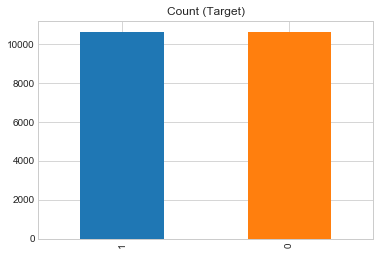

In [59]:
x_train_class_0_under = x_train_class_0.sample(count_class_1)
x_train_train_under = pd.concat([x_train_class_0_under, x_train_class_1], axis=0)

print('Random under-sampling:\n', x_train_train_under.res.value_counts())

x_train_train_under.res.value_counts().plot(kind='bar', title='Count (Target)');

In [60]:
x_train, y_train, x_test, y_test = x_train_train_under.iloc[:,:26], x_train_train_under.res, x_test_org.iloc[:,:26], x_test_org.res

In [61]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
predictions = lr.predict(x_train)
prediction_probs = lr.predict_proba(x_train)
score_res(y_train, predictions, prediction_probs)

Log Loss : 0.5868318584736965
AUC precision-recall curve : 0.6899183189505314
F1 Score: 0.7048277068392514
F2 Score: 0.7347470916450896
Accuracy : 0.6833364608744605

 Confusion Matrix : 
 [[6507 4151]
 [2599 8059]]


In [63]:
predictions = lr.predict(x_test)
prediction_probs = lr.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 0.5952813187902236
AUC precision-recall curve : 0.14153230848606152
F1 Score: 0.2103134479271992
F2 Score: 0.369801998727402
Accuracy : 0.6279646993932708

 Confusion Matrix : 
 [[23071 14173]
 [  666  1976]]


In [64]:
int_conf_mat(y_test, predictions)

### Random Over-sampling

Random over-sampling:
 1    148883
0    148883
Name: res, dtype: int64


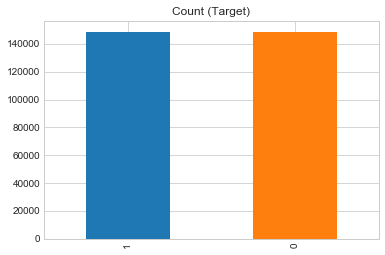

In [65]:
x_train_class_1_over = x_train_class_1.sample(count_class_0, replace=True)
x_train_train_over = pd.concat([x_train_class_0, x_train_class_1_over], axis=0)

print('Random over-sampling:\n', x_train_train_over.res.value_counts())

x_train_train_over.res.value_counts().plot(kind='bar', title='Count (Target)');

In [66]:
x_train, y_train, x_test, y_test = x_train_train_over.iloc[:,:26], x_train_train_over.res, x_test_org.iloc[:,:26], x_test_org.res

In [67]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
predictions = lr.predict(x_train)
prediction_probs = lr.predict_proba(x_train)
score_res(y_train, predictions, prediction_probs)

Log Loss : 0.5837172853004717
AUC precision-recall curve : 0.698841346951082
F1 Score: 0.7080750014105079
F2 Score: 0.7375767778571551
Accuracy : 0.6872241961808937

 Confusion Matrix : 
 [[ 91682  57201]
 [ 35933 112950]]


In [69]:
predictions = lr.predict(x_test)
prediction_probs = lr.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 0.5968263753509349
AUC precision-recall curve : 0.14101460251066963
F1 Score: 0.20993419656123966
F2 Score: 0.3694434067986552
Accuracy : 0.6267361981647696

 Confusion Matrix : 
 [[23020 14224]
 [  664  1978]]


In [70]:
int_conf_mat(y_test, predictions)

### SMOTE + Tomek links (Synthetic Minority oversampling followed by Tomek Links)

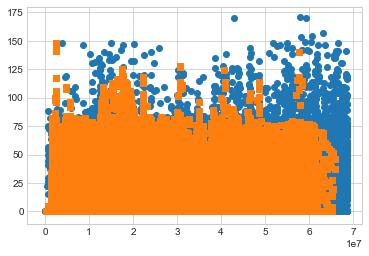

In [71]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(x_train_org.iloc[:,:26], x_train_org.res)
colors = ['#1F77B4', '#FF7F0E']
markers = ['o', 's']
for l, c, m in zip(np.unique(y_smt), colors, markers):
        plt.scatter(
            X_smt[y_smt==l, 0],
            X_smt[y_smt==l, 1],
            c=c, label=l, marker=m
        )

In [72]:
X_smt.shape, y_smt.shape

((287054, 26), (287054,))

In [73]:
x_train, y_train, x_test, y_test = X_smt, y_smt, x_test_org.iloc[:,:26], x_test_org.res

In [74]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
predictions = lr.predict(x_train)
prediction_probs = lr.predict_proba(x_train)
score_res(y_train, predictions, prediction_probs)

Log Loss : 0.5752610549018015
AUC precision-recall curve : 0.7032418355517397
F1 Score: 0.7137570950252503
F2 Score: 0.7423268367443816
Accuracy : 0.69413768837919

 Confusion Matrix : 
 [[ 89790  53737]
 [ 34062 109465]]


In [76]:
predictions = lr.predict(x_test)
prediction_probs = lr.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 0.6014883064447079
AUC precision-recall curve : 0.1405623404850645
F1 Score: 0.2099353882004025
F2 Score: 0.3696657714115189
Accuracy : 0.6259840545554831

 Confusion Matrix : 
 [[22986 14258]
 [  660  1982]]


In [77]:
int_conf_mat(y_test, predictions)

- We can see best results, out of the three sampling techniques, in SMOTE + Tomek links technique. We'll tune the hyperparameters for this sampled dataset and try other model which can possibly perform better.

### Hyperparameter tuning for Logistic Regression

In [78]:
lr = LogisticRegression()

print('Best Hyperparameters -')

# regularization penalty options
penalty = ['l2']

# regularization hyperparameter options
C = [1.0, 4.0, 10]

# hyperparameter dictionary
hyperparameters = dict(C=C, penalty=penalty, n_jobs=[-1])

# grid search using 3-fold cross validation
clf = GridSearchCV(lr, hyperparameters, cv=3, verbose=0, scoring='f1')

# Fit grid search
best_model = clf.fit(x_train, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Hyperparameters -
Best Penalty: l2
Best C: 1.0


In [79]:
# Prediction using best model
predictions = best_model.predict(x_test)
prediction_probs = best_model.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 0.6014883064447148
AUC precision-recall curve : 0.1405623404850645
F1 Score: 0.2099353882004025
F2 Score: 0.3696657714115189
Accuracy : 0.6259840545554831

 Confusion Matrix : 
 [[22986 14258]
 [  660  1982]]


### Model - Random Forest classifier with Hyperparemeter tuning

In [80]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [81]:
predictions = rfc.predict(x_test)
prediction_probs = rfc.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 0.7001639635821434
AUC precision-recall curve : 0.11211225331334287
F1 Score: 0.05779280664002459
F2 Score: 0.04204311655783165
Accuracy : 0.923155994584566

 Confusion Matrix : 
 [[36727   517]
 [ 2548    94]]


In [83]:
## Hyperparameter Tuning

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 80],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [4, 10],
    'n_estimators': [50, 300]
}
# Create a based model
rfc = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1, scoring='f1')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [40], 'min_samples_leaf': [3], 'min_samples_split': [4], 'n_estimators': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [84]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 50}

In [85]:
best_grid = grid_search.best_estimator_
predictions = best_grid.predict(x_test)
prediction_probs = best_grid.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 0.2634446042160342
AUC precision-recall curve : 0.13834494683654425
F1 Score: 0.04193011647254576
F2 Score: 0.028817125606074464
Accuracy : 0.927819284962142

 Confusion Matrix : 
 [[36944   300]
 [ 2579    63]]


In [86]:
int_conf_mat(y_test, predictions)

In [95]:
feature_importances = pd.DataFrame(data= {'columns': x_train_org.columns[:26], 'importance': best_grid.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', axis=0, ascending=False)
feature_importances

,columns,importance
6,home_ownership,0.142741
9,verification_status,0.132770
14,apply_Year,0.087393
19,apply_Elapsed,0.085471
3,purpose,0.084982
10,emp_length,0.060832
0,id,0.055900
5,title,0.055220
4,addr_state,0.045325
11,dti,0.020163


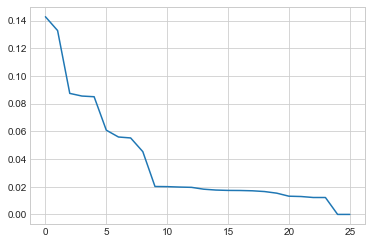

In [96]:
plt.plot(np.arange(len(feature_importances)), feature_importances.importance)

- As we can see Feature importance drops severely after 8 features. So, to make the final model less complex and easier to maintain we should train it on top 8 features which would give us approximately the same results.

### Fitting KNN

- Being an algorithm which is easy to implement and understand, KNN is a good choice to experiment.
- It sometimes might give better results than other complicated algorithms if the points are distinctly seperated in the vector space 

In [97]:
knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
           weights='uniform')

In [98]:
predictions = knn.predict(x_test)
prediction_probs = knn.predict_proba(x_test)
score_res(y_test, predictions, prediction_probs)

Log Loss : 2.1517802795410503
AUC precision-recall curve : 0.09232739773304419
F1 Score: 0.16388713603173172
F2 Score: 0.23897155476102847
Accuracy : 0.7674622674622674

 Confusion Matrix : 
 [[29702  7542]
 [ 1733   909]]


In [99]:
int_conf_mat(y_test, predictions)

## Comments

---------

- We have tried three different type of models here. And we are tuning hyperparameters to optimize F1 score.
- We can use Logistic regression or Random Forest model from these to go ahead with our predictions. The performance of both models is comparable and we can choose one of them based on our use-case. 
- We can also see that KNN increases the number of positive predictions, which is a good thing and can be used to optimize sampling.
- We could have used feature engineering techniques (target encoding, feature generation, etc.) with some knowledge about the features and the target variable.
- We can also use other anomaly detection and class balancing techniques with some knowledge of the variables and the exact requirement about the class we need to optimize.

# Q-3

- To decide a hard cutoff for accepting loans we will keep following things in mind:
    - We want to maximize the precision of True Negatives (non-defaulters). Those people can directly be approved without any doubt.
    - For people with Predicted positive (predicted as defaulters), predictions with high probablity can be directly rejected. And for people with probability closer to the threshold, they can be sent for a review by the team.
    - In a real world setting, we want to make sure that we only accept and reject people about whom we are totally sure (precise). Any doubtful cases can be sent for a manual review.
    - Plus when approving a loan, even with a high probability, we would want to pass it through a rule based approach at the end based on rules such as credit score above a threshold, annual income above a threshold, etc. so that every prediction by the model passes a certain criteria.